# Myopic Foresight, Comparison of COnfigurations without and with time delay
## Secondary evaluation of ability to limit min/max capacity after the technology is activated 

Author: Katherine Shaw 

Date: June 4, 2025 


In [4]:
#importing packages and functions
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import Auxillary_Functions as af

In [5]:
def capacities(network):
    #returns the installed capacity of each generator in MW
    #this is the installed capacity, not the dispatch, so it is not affected by the snapshot weightings
    
    #The choices of what to include regarding the statistics component has been made, not arbitrarily but not with any official relation aside from what I view as important
    electric_stats_carriers_generators = [
    (  'Generator',                'Offshore Wind (AC)'),
    (  'Generator',                'Offshore Wind (DC)'),
    (  'Generator',          'Offshore Wind (Floating)'),
    (  'Generator',                      'Onshore Wind'),
    (  'Generator',                      'Run of River'),
    (  'Generator',                             'Solar'),
    (  'Generator',                     'solar rooftop'),
    (  'Generator',                        'solar-hsat'),
    #(  'Generator',                            'biogas'), #used for heating
    #(  'Generator',                              'coal'), #should be represented as link
    #(  'Generator',                               'gas'), #used for heating
    (  'Generator',                        'geothermal'),
    #(  'Generator',                           'lignite'), #should be represented as link
    (  'Generator',                           'nuclear'),
    #(  'Generator',                       'oil primary'), #should only be used for the transport sector
    #(  'Generator',               'rural solar thermal'), #should only be used for heating sector
    #(  'Generator',                     'solid biomass'), #should only be used to convert into gas bus, and then gas is used for heating or represented as OCGT or CCGT
    #(  'Generator',           'urban central heat vent'), #used to absorb excess energy 
    #(  'Generator',       'urban central solar thermal'), #should only be used for the heating sector
    #(  'Generator',     'urban decentral solar thermal'), #should only be used for the heating sector? 
    ]

    electric_stats_carriers_links = [
        #(       'Link',                       'BEV charger'),
        (       'Link',                'Combined-Cycle Gas'), #to represent conventional carrier usage
        (       'Link',                    'Open-Cycle Gas'), #to represent conventional carrier usage
        (       'Link',                              'coal'), #to represent conventional carrier usage
        (       'Link',                             'lignite'), #to represent conventional carrier usage
        (       'Link',                   'H2 Electrolysis'),
        #(       'Link',              'home battery charger'), #going to look at home battery store instead
        #(       'Link',           'home battery discharger'), #going to look at home battery store instead
        #(       'Link',               'rural air heat pump'),
        #(       'Link',       'urban central air heat pump'),
        #(       'Link',     'urban decentral air heat pump'),
        (       'Link',                   'H2 Fuel Cell'),
        (       'Link',                   'H2 pipeline'),
        (       'Link',                   'SMR'),
        (       'Link',                   'SMR CC'),

     
        ]

    electric_stats_carriers_stores = [
        (      'Store',                   'Battery Storage'),
        (      'Store',                          'H2 Store'),
        (      'Store',                      'home battery'),
        #(      'Store',                           'lignite'),
        #(      'Store',                               'oil'),
    ]

    
    network.statistics().loc[electric_stats_carriers_generators]['Optimal Capacity'].div(1e3).plot.barh()
    plt.xlabel('Optimal Capacity [GW]')
    plt.show()
    network.statistics().loc[electric_stats_carriers_links]['Optimal Capacity'].div(1e3).plot.barh()
    plt.xlabel('Optimal Capacity [GW]')
    plt.show()
    network.statistics().loc[electric_stats_carriers_stores]['Optimal Capacity'].div(1e3).plot.barh()
    plt.xlabel('Optimal Capacity [GW]')
    plt.show()


    return None 

Loading The Networks 

In [3]:
#The older myopic tests
filepath20 = '/Users/katherine.shaw/Desktop/June4_pypsa-eur copy_(myopic_tests, many_simplifications_from_defualt)/results/networks/base_s_39___2020.nc'
filepath30 = '/Users/katherine.shaw/Desktop/June4_pypsa-eur copy_(myopic_tests, many_simplifications_from_defualt)/results/networks/base_s_39___2030.nc'
filepath40 = '/Users/katherine.shaw/Desktop/June4_pypsa-eur copy_(myopic_tests, many_simplifications_from_defualt)/results/networks/base_s_39___2040.nc'
filepath50 = '/Users/katherine.shaw/Desktop/June4_pypsa-eur copy_(myopic_tests, many_simplifications_from_defualt)/results/networks/base_s_39___2050.nc'
myopic_network20 = pypsa.Network(filepath20)
myopic_network30 = pypsa.Network(filepath30)
myopic_network40 = pypsa.Network(filepath40)
myopic_network50 = pypsa.Network(filepath50)

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [41]:
#The myopic tests where all hydrogen components (SMR, SMR CC, H2 Electrolysis, H2 pipeline, H2 Fuel Cell) are prohibited until 2030 
filepath20 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc'
filepath30 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc'
filepath40 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc'
filepath50 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc'
myopic_constrained2030_20 = pypsa.Network(filepath20)
myopic_constrained2030_30 = pypsa.Network(filepath30)
myopic_constrained2030_40 = pypsa.Network(filepath40)
myopic_constrained2030_50 = pypsa.Network(filepath50)

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [16]:
#The myopic tests where all hydrogen components (SMR, SMR CC, H2 Electrolysis, H2 pipeline, H2 Fuel Cell) are prohibited until 2030 
filepath20 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks_hydrogen_constraint_to_after_2040/base_s_39___2020.nc'
filepath30 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks_hydrogen_constraint_to_after_2040/base_s_39___2030.nc'
filepath40 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks_hydrogen_constraint_to_after_2040/base_s_39___2040.nc'
filepath50 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks_hydrogen_constraint_to_after_2040/base_s_39___2050.nc'
myopic_constrained2040_20 = pypsa.Network(filepath20)
myopic_constrained2040_30 = pypsa.Network(filepath30)
myopic_constrained2040_40 = pypsa.Network(filepath40)
myopic_constrained2040_50 = pypsa.Network(filepath50)

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Use of the constrained outputs over time
- (1) SMR 
- (2) SMR CC 
- (3) H2 Electrolysis 
- (4) H2 pipeline
- (5) H2 Fuel Cell


In [5]:
#I want a function that for any item, compares it across multiple networks, 
#for everything but stores and storage units, it can be installed capcity in MW (or whatever n.statitistics returns)

def compare_networks(networks, item):
    import re 
    """
    Compare a specific item across multiple networks.
    
    Parameters:
    networks (list): List of pypsa.Network objects.
    item (tuple): The item to compare that is present in the statistics DataFrame, such as ('Generator', 'Solar').
    
    Returns:
    pd.DataFrame: DataFrame containing the comparison results.
    """
    years = [2020, 2030, 2040, 2050]
    years_count = 0
    comparison_dataframe = pd.DataFrame(columns=['Year', 'Item', 'Value', 'Unit'])
    for i in networks:
        
        # Extract year from the file path (last 4 digits before .nc)
        if item in i.statistics().index:
            value = i.statistics().loc[item, 'Installed Capacity']
            comparison_dataframe.loc[len(comparison_dataframe)] = {'Year': years[years_count], 'Item': item, 'Value': value, 'Unit': 'MW'}
        else:
            print(f"Item {item} not found in network {i.name}.")
        years_count += 1
    return comparison_dataframe
    
    

In [6]:
compare_networks([myopic_network20, myopic_network30, myopic_network40, myopic_network50], ('Link', 'SMR'))

,Year,Item,Value,Unit
0,2020,"(Link, SMR)",0.0000,MW
1,2030,"(Link, SMR)",13909.5606,MW
2,2040,"(Link, SMR)",13909.5606,MW
3,2050,"(Link, SMR)",0.0000,MW


<Figure size 800x500 with 0 Axes>

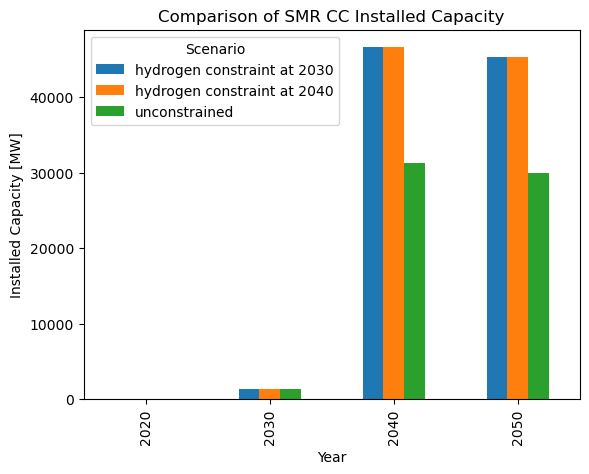

<Figure size 800x500 with 0 Axes>

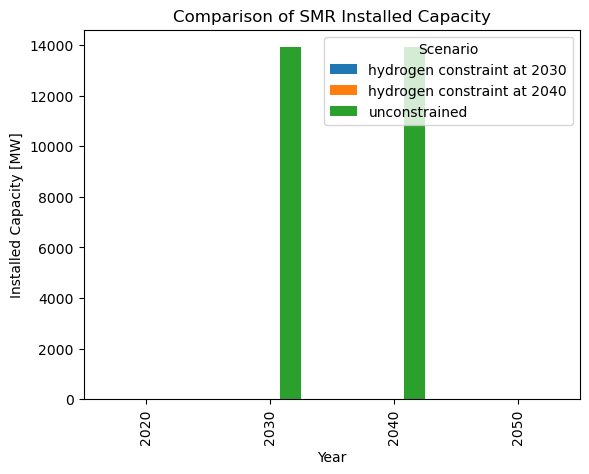

<Figure size 800x500 with 0 Axes>

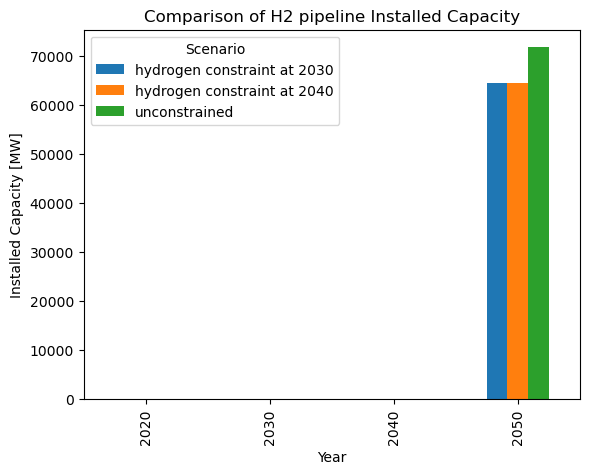

<Figure size 800x500 with 0 Axes>

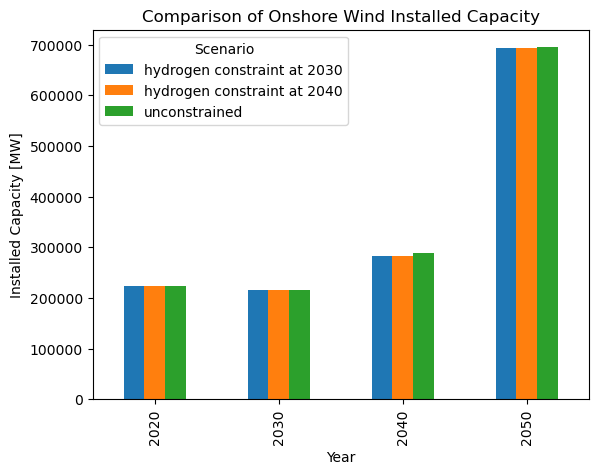

<Figure size 800x500 with 0 Axes>

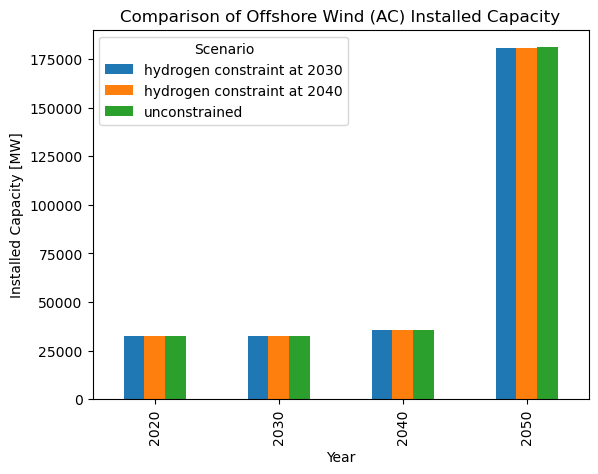

<Figure size 800x500 with 0 Axes>

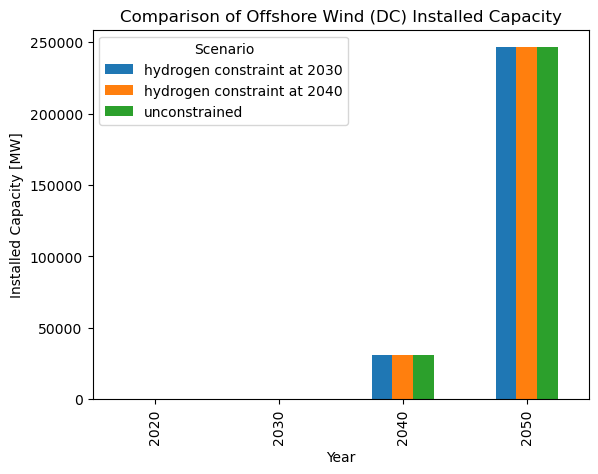

<Figure size 800x500 with 0 Axes>

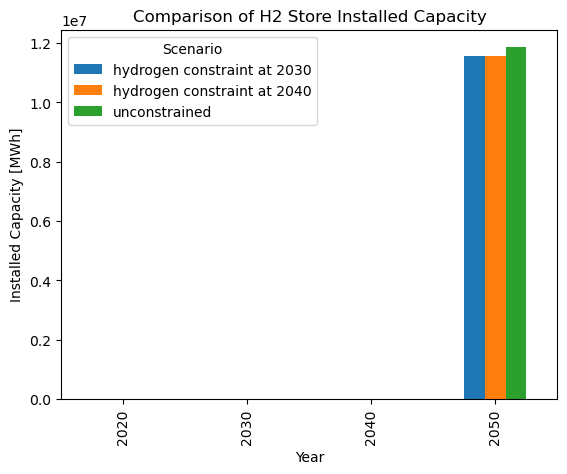

In [42]:
# Get data for both scenarios
def compare_networks(networks, component, technology):
    """
    Compare a specific component and technology across multiple networks.

    Parameters:
    networks (list): List of pypsa.Network objects.
    component (str): The component type, e.g., 'Generator', 'Link', 'Store'.
    technology (str): The technology/carrier name, e.g., 'Solar', 'H2 Store'.

    Returns:
    pd.DataFrame: DataFrame containing the comparison results.
    """
    years = [2020, 2030, 2040, 2050]
    comparison_dataframe = pd.DataFrame(columns=['Year', 'Item', 'Value', 'Unit'])
    for idx, net in enumerate(networks):
        item = (component, technology)
        if item in net.statistics().index:
            value = net.statistics().loc[item, 'Installed Capacity'] #difference between Installed Capacity and Optimal Capacity
            comparison_dataframe.loc[len(comparison_dataframe)] = {
                'Year': years[idx], 'Item': item, 'Value': value, 'Unit': 'MW'
            }
        else:
            print(f"Item {item} not found in network {getattr(net, 'name', idx)}.")
    return comparison_dataframe

def plot_installed_capacity_comparison(network_set1, networks_label1, network_set2, networks_label2, network_set3, networks_label3, component, technology):
    """
    Plots a grouped bar chart comparing installed capacity of a given component and technology
    across two sets of networks (e.g., unconstrained vs constrained scenarios).

    Parameters:
    network_set1 (list): List of pypsa.Network objects for scenario 1.
    network_set2 (list): List of pypsa.Network objects for scenario 2.
    component (str): The component type, e.g., 'Generator', 'Link', 'Store'.
    technology (str): The technology/carrier name, e.g., 'Solar', 'H2 Store'.
    """
    years = [2020, 2030, 2040, 2050]
    '''
    def compare_networks(networks, component, technology):
        comparison_dataframe = pd.DataFrame(columns=['Year', 'Item', 'Value', 'Unit'])
        for idx, net in enumerate(networks):
            item = (component, technology)
            if item in net.statistics().index:
                value = net.statistics().loc[item, 'Installed Capacity']
                comparison_dataframe.loc[len(comparison_dataframe)] = {
                    'Year': years[idx], 'Item': item, 'Value': value, 'Unit': 'MW'
                }
            else:
                print(f"Item {item} not found in network {getattr(net, 'name', idx)}.")
        return comparison_dataframe
    '''
    df1 = compare_networks(network_set1, component, technology)
    df1['Scenario'] = networks_label1
    df2 = compare_networks(network_set2, component, technology)
    df2['Scenario'] = networks_label2
    df3 = compare_networks(network_set3, component, technology)
    df3['Scenario'] = networks_label3

    df_combined = pd.concat([df1, df2])
    df_combined = pd.concat([df_combined, df3])
    df_pivot = df_combined.pivot(index='Year', columns='Scenario', values='Value')

    # Set unit
    unit = 'MWh' if component == 'Store' else 'MW'
    plt.figure(figsize=(8, 5))
    df_pivot.plot(kind='bar')
    plt.ylabel(f'Installed Capacity [{unit}]')
    plt.title(f'Comparison of {technology} Installed Capacity')
    plt.show()

    return None 

plot_installed_capacity_comparison(
    [myopic_network20, myopic_network30, myopic_network40, myopic_network50], 'unconstrained',
    [myopic_constrained2030_20, myopic_constrained2030_30, myopic_constrained2030_40, myopic_constrained2030_50], 'hydrogen constraint at 2030',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',
    'Link', 'SMR CC'
)

plot_installed_capacity_comparison(
    [myopic_network20, myopic_network30, myopic_network40, myopic_network50], 'unconstrained',
    [myopic_constrained2030_20, myopic_constrained2030_30, myopic_constrained2030_40, myopic_constrained2030_50], 'hydrogen constraint at 2030',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',
    'Link', 'SMR'
)

plot_installed_capacity_comparison(
    [myopic_network20, myopic_network30, myopic_network40, myopic_network50], 'unconstrained',
    [myopic_constrained2030_20, myopic_constrained2030_30, myopic_constrained2030_40, myopic_constrained2030_50], 'hydrogen constraint at 2030',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',
    'Link', 'H2 pipeline'
)

plot_installed_capacity_comparison(
    [myopic_network20, myopic_network30, myopic_network40, myopic_network50], 'unconstrained',
    [myopic_constrained2030_20, myopic_constrained2030_30, myopic_constrained2030_40, myopic_constrained2030_50], 'hydrogen constraint at 2030',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',
    'Generator', 'Onshore Wind'
)

plot_installed_capacity_comparison(
    [myopic_network20, myopic_network30, myopic_network40, myopic_network50], 'unconstrained',
    [myopic_constrained2030_20, myopic_constrained2030_30, myopic_constrained2030_40, myopic_constrained2030_50], 'hydrogen constraint at 2030',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',
    'Generator', 'Offshore Wind (AC)'
)
plot_installed_capacity_comparison(
    [myopic_network20, myopic_network30, myopic_network40, myopic_network50], 'unconstrained',
    [myopic_constrained2030_20, myopic_constrained2030_30, myopic_constrained2030_40, myopic_constrained2030_50], 'hydrogen constraint at 2030',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',
    'Generator', 'Offshore Wind (DC)'
)

plot_installed_capacity_comparison(
    [myopic_network20, myopic_network30, myopic_network40, myopic_network50], 'unconstrained',
    [myopic_constrained2030_20, myopic_constrained2030_30, myopic_constrained2030_40, myopic_constrained2030_50], 'hydrogen constraint at 2030',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',
    'Store', 'H2 Store'
)


In [38]:
myopic_network40.statistics() 

Optimal Capacity  Installed Capacity  \
Generator Offshore Wind (AC)               2.030522e+05         35726.63770   
          Offshore Wind (DC)               2.464756e+05         31191.44808   
          Offshore Wind (Floating)         4.262000e-02             0.00000   
          Onshore Wind                     8.006021e+05        288147.27639   
          Run of River                     4.834167e+04         48341.66702   
...                                                 ...                 ...   
Store     oil                              1.459419e+01             0.00000   
          rural water tanks                6.807000e-02             0.00000   
          uranium                          2.844000e-01             0.00000   
          urban central water tanks        6.702883e+06        506134.31510   
          urban decentral water tanks      6.545000e-02             0.00000   

                                             Supply    Withdrawal  \
Generator Offshore Wind (AC)           8.876716e+08  0.000000e+00   
          Offshore Wind (DC)           1.261037e+09  0.000000e+00   
          Offshore Wind (Floating)     1.267585e+02  0.000000e+00   
          Onshore Wind                 2.209678e+09  0.000000e+00   
          Run of River                 1.542885e+08  0.000000e+00   
...                                             ...           ...   
Store     oil                          6.516423e+01  6.516423e+01   
          rural water tanks            4.616550e+00  8.391980e+00   
          uranium                      7.870000e-03  7.870000e-03   
          urban central water tanks    1.582997e+08  1.642731e+08   
          urban decentral water tanks  4.788890e+00  8.382940e+00   

                                       Energy Balance  Transmission  \
Generator Offshore Wind (AC)             8.876716e+08           0.0   
          Offshore Wind (DC)             1.261037e+09           0.0   
          Offshore Wind (Floating)       1.267585e+02           0.0   
          Onshore Wind                   2.209678e+09           0.0   
          Run of River                   1.542885e+08           0.0   
...                                               ...           ...   
Store     oil                            0.000000e+00           0.0   
          rural water tanks             -3.775430e+00           0.0   
          uranium                        0.000000e+00           0.0   
          urban central water tanks     -5.973388e+06           0.0   
          urban decentral water tanks   -3.594050e+00           0.0   

                                       Capacity Factor   Curtailment  \
Generator Offshore Wind (AC)                  0.499046  2.130447e+07   
          Offshore Wind (DC)                  0.584050  1.951474e+06   
          Offshore Wind (Floating)            0.339512  3.084019e+01   
          Onshore Wind                        0.315071  1.046945e+08   
          Run of River                        0.364341  9.193898e+04   
...                                                ...           ...   
Store     oil                                 0.502586  0.000000e+00   
          rural water tanks                   0.475687  0.000000e+00   
          uranium                             0.013783  0.000000e+00   
          urban central water tanks           0.439785  0.000000e+00   
          urban decentral water tanks         0.469366  0.000000e+00   

                                       Capital Expenditure  \
Generator Offshore Wind (AC)                  4.011370e+10   
          Offshore Wind (DC)                  5.386652e+10   
          Offshore Wind (Floating)            9.094499e+03   
          Onshore Wind                        9.132261e+10   
          Run of River                        1.489747e+10   
...                                                    ...   
Store     oil                                 3.983112e+01   
          rural water tanks                   2

conventional  geothermal    8.580687e+05
              nuclear       6.792848e+08
              CCGT          1.064459e+07
              OCGT          8.463906e+02
              coal          1.546951e+05
              lignite       2.523022e+05
dtype: float64
renewable  offwind-ac       8.876716e+08
           offwind-dc       1.261037e+09
           offwind-float    1.267585e+02
           onwind           2.209678e+09
           ror              1.542885e+08
           solar            1.162474e+09
           solar rooftop    1.204892e+09
           solar-hsat       1.168472e+08
dtype: float64
Unconstrainted network 2040
conventional  geothermal    8.582600e+05
              nuclear       7.598714e+08
              CCGT          1.626462e+08
              OCGT          3.842557e+01
              coal          8.225257e+01
              lignite       1.965754e+07
dtype: float64
renewable  offwind-ac       1.785004e+08
           offwind-dc       1.656383e+08
           offwind-float 

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:379: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:390: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:379: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/p

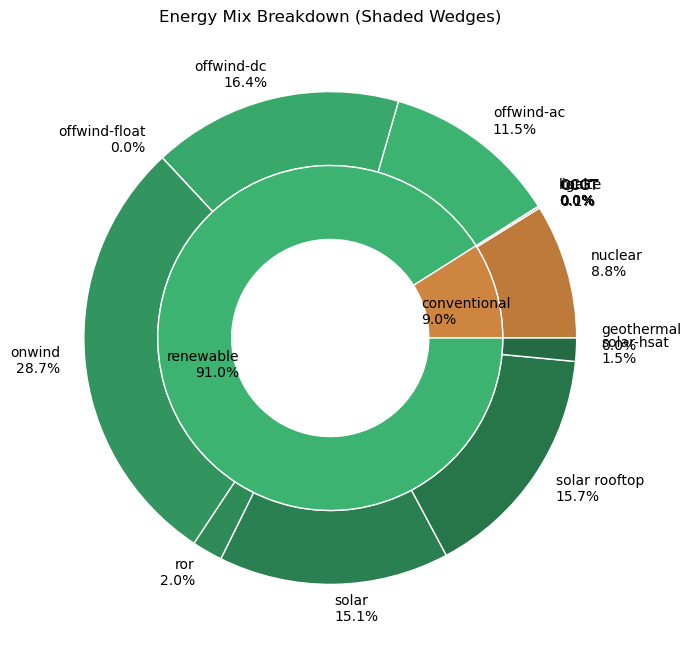

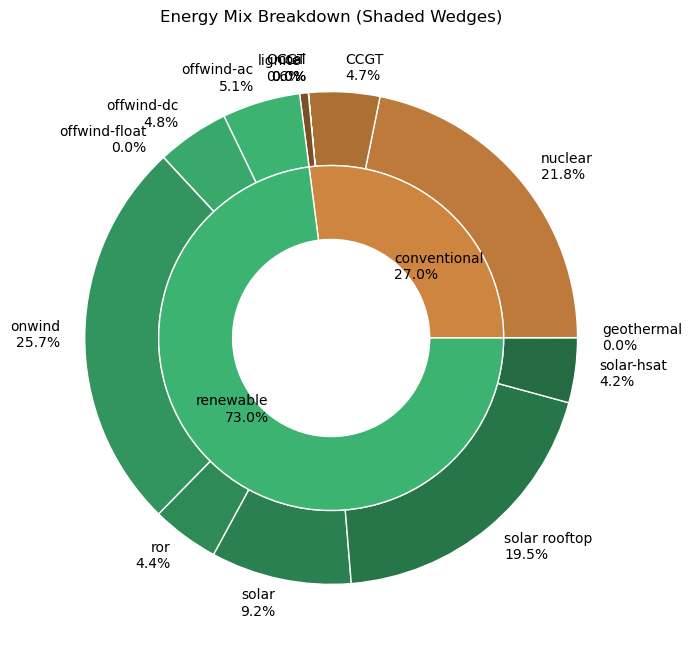

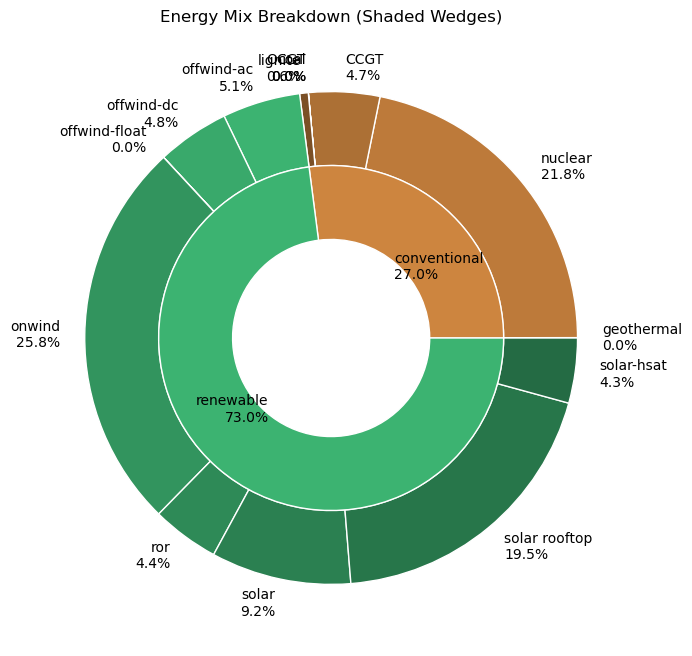

In [24]:

af.carrier_pie_chart(myopic_network40)
print('Unconstrainted network 2040')
af.carrier_pie_chart(myopic_constrained2030_30)
print('Unconstrained network 2030 delay')
af.carrier_pie_chart(myopic_constrained2040_30)
print('Unconstrained network 2040 delay')

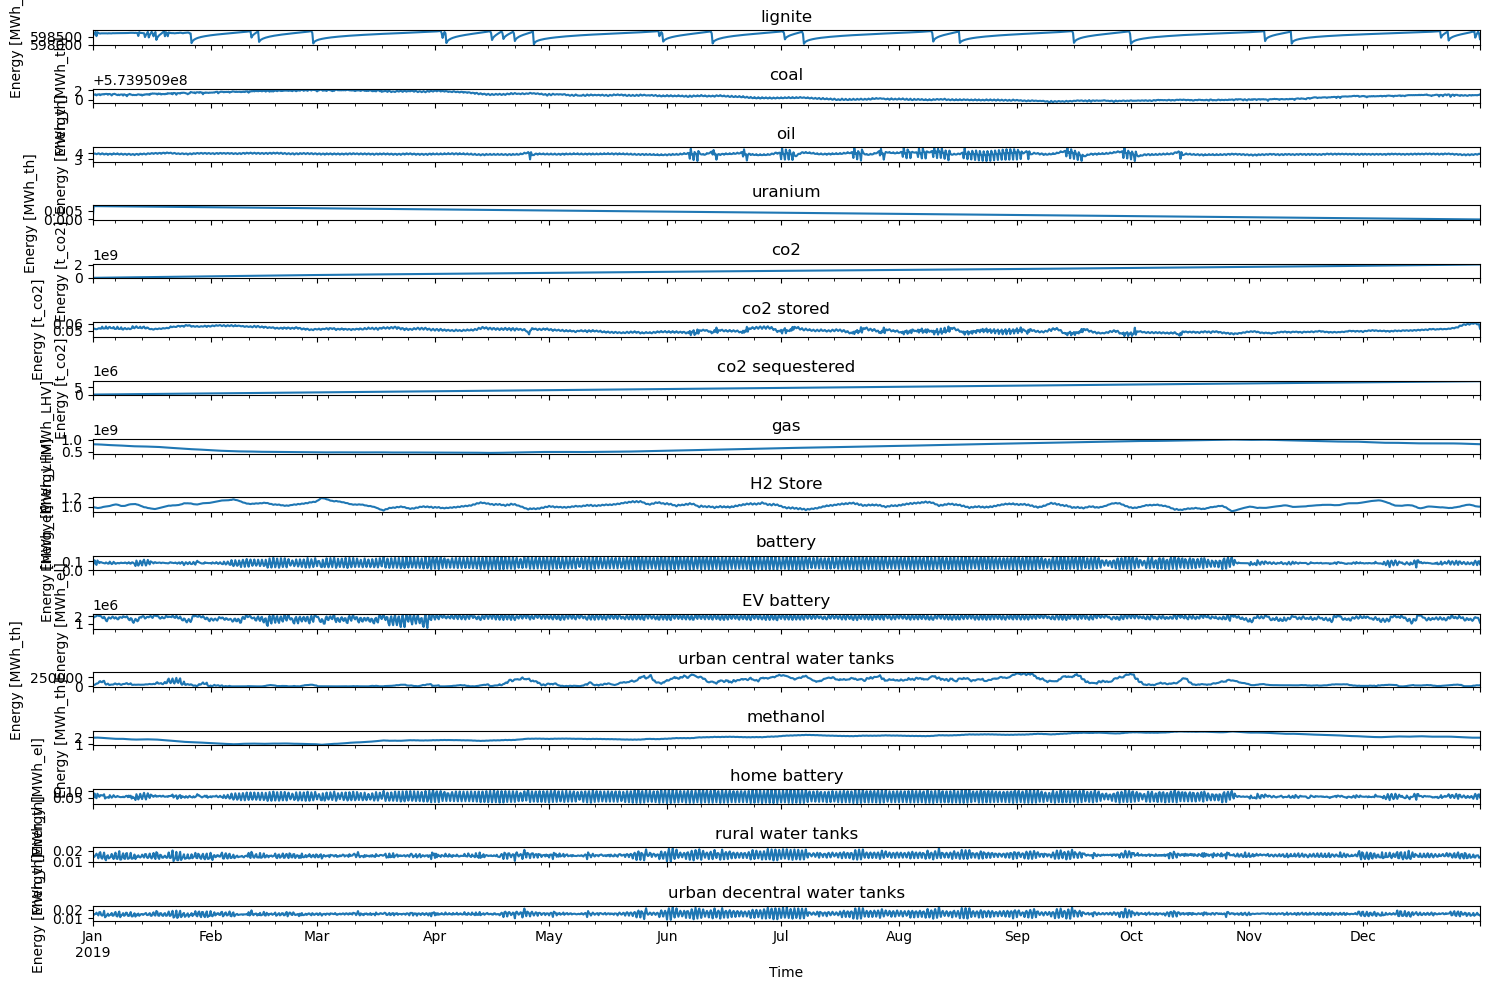

In [36]:
#All dipatch plus load doesn't really reveal much about the changes in system structure 

af.plot_store_energy_by_carrier(myopic_network30, figsize=(15, 10))

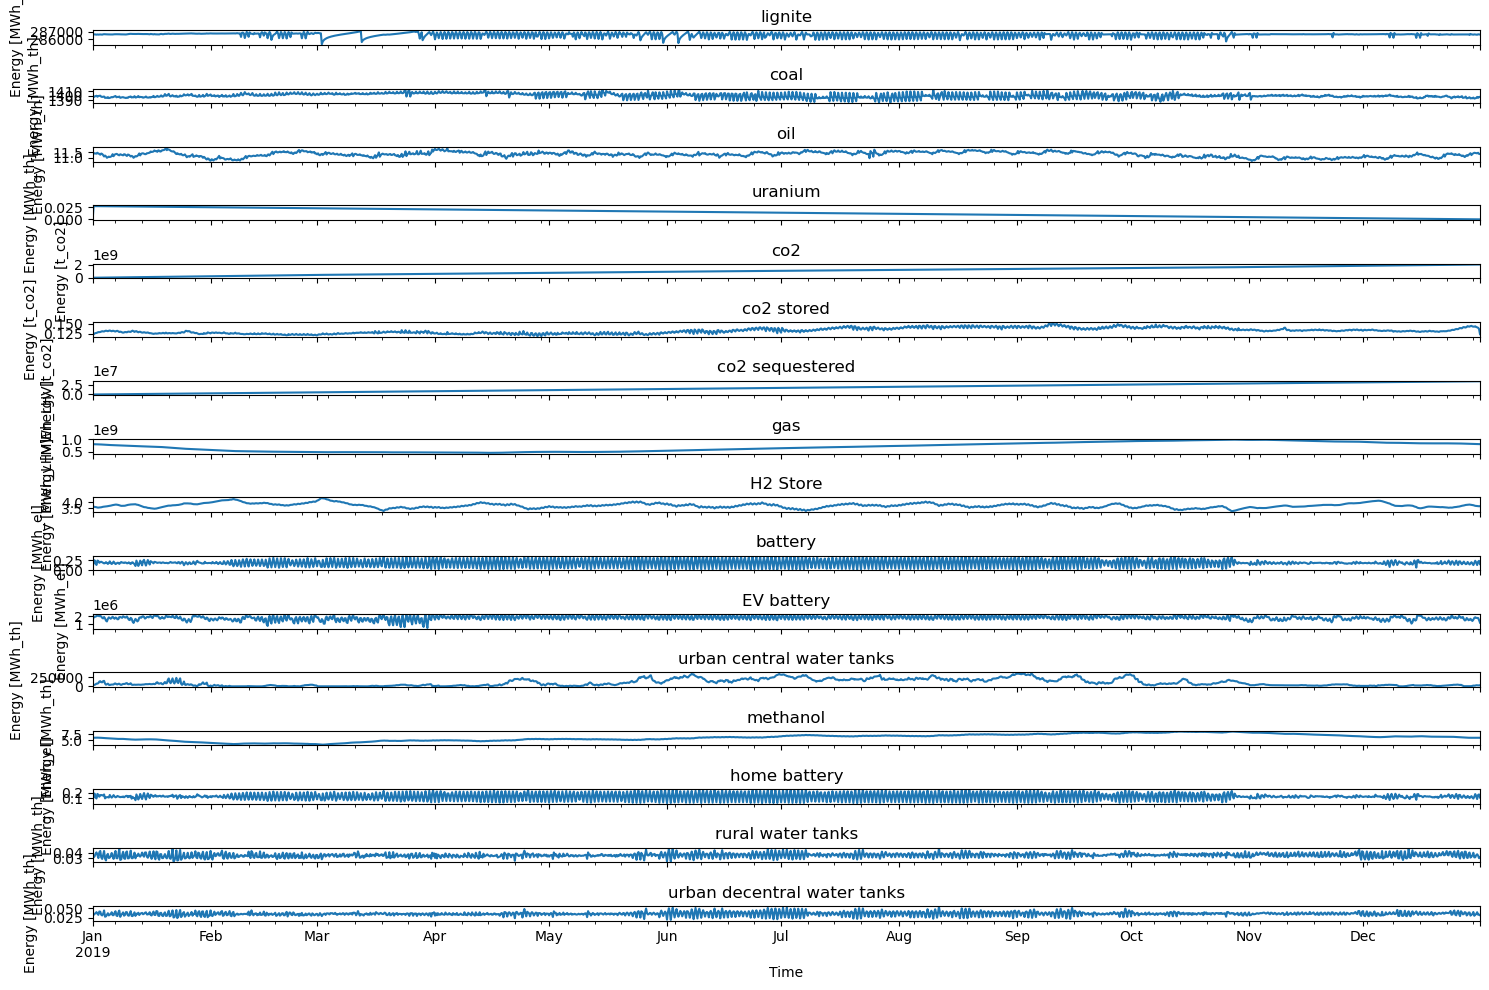

In [35]:
af.plot_store_energy_by_carrier(myopic_constrained2030_30, figsize=(15, 10))

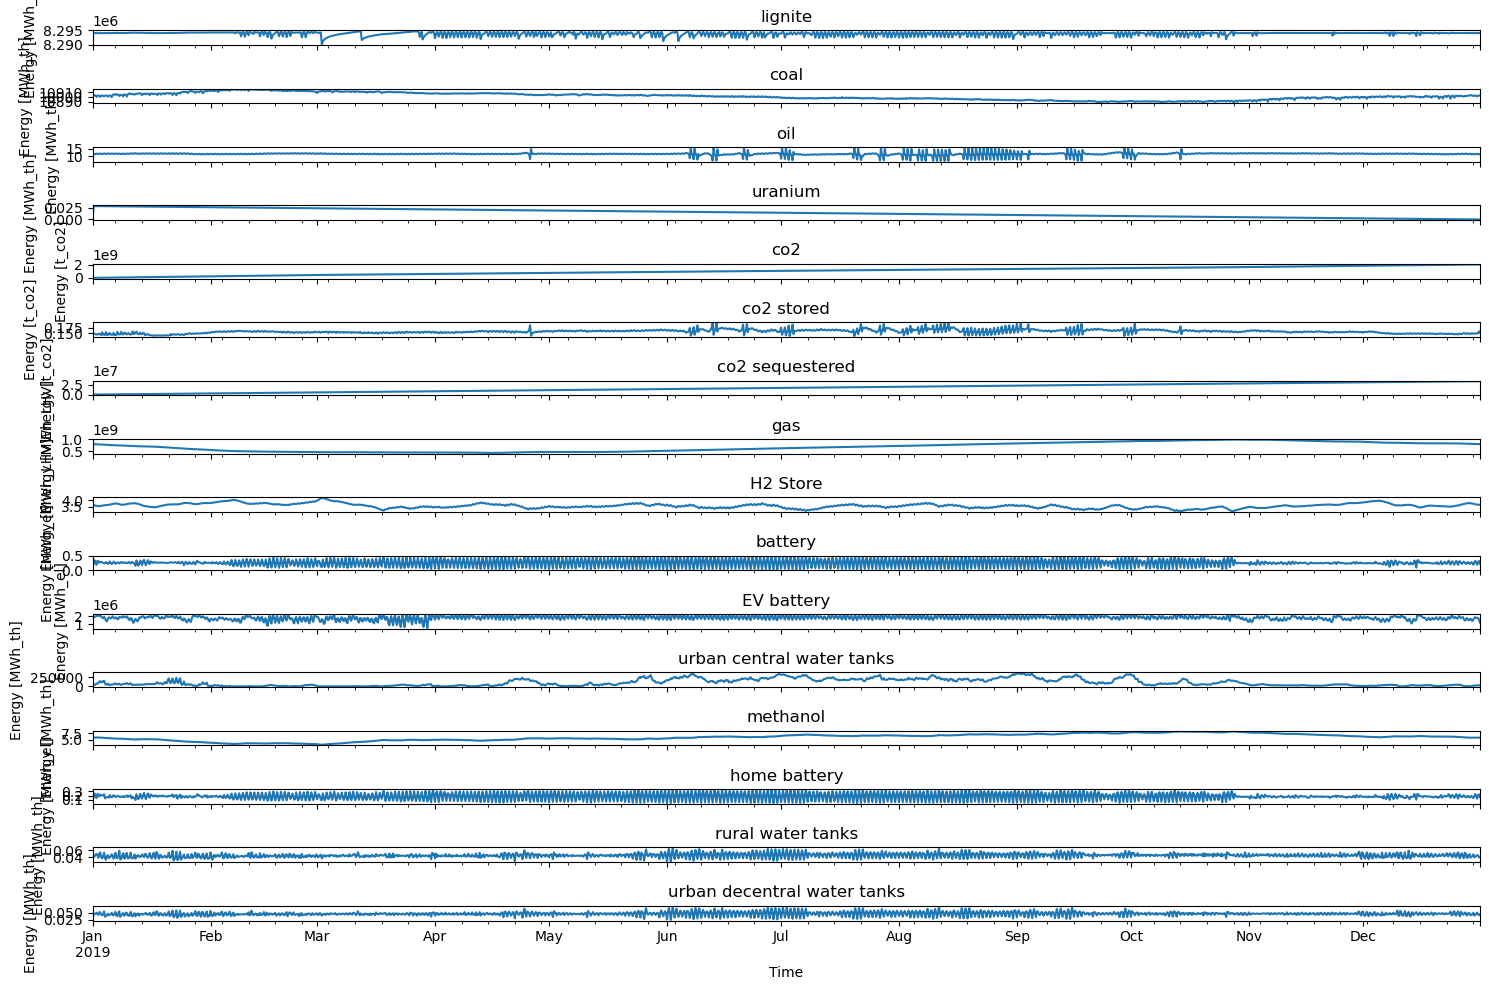

In [34]:
af.plot_store_energy_by_carrier(myopic_constrained2040_30, figsize=(15, 10))

('Generator', 'Offshore Wind (AC)')
('Generator', 'Offshore Wind (DC)')
('Generator', 'Offshore Wind (Floating)')
('Generator', 'Onshore Wind')
('Generator', 'Run of River')
('Generator', 'Solar')
('Generator', 'biogas')
('Generator', 'coal')
('Generator', 'gas')
('Generator', 'geothermal')
('Generator', 'lignite')
('Generator', 'nuclear')
('Generator', 'oil primary')
('Generator', 'residential rural solar thermal')
('Generator', 'residential urban decentral solar thermal')
('Generator', 'solar rooftop')
('Generator', 'solar-hsat')
('Generator', 'solid biomass')
('Generator', 'unsustainable biogas')
('Generator', 'unsustainable bioliquids')
('Generator', 'unsustainable solid biomass')
('Generator', 'urban central heat vent')
('Generator', 'urban central solar thermal')
('Line', 'AC')
('Link', 'Combined-Cycle Gas')
('Link', 'DC')
('Link', 'Fischer-Tropsch')
('Link', 'H2 Electrolysis')
('Link', 'H2 Fuel Cell')
('Link', 'H2 pipeline')
('Link', 'Open-Cycle Gas')
('Link', 'SMR')
('Link', 'S

INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, 

<Figure size 800x500 with 0 Axes>

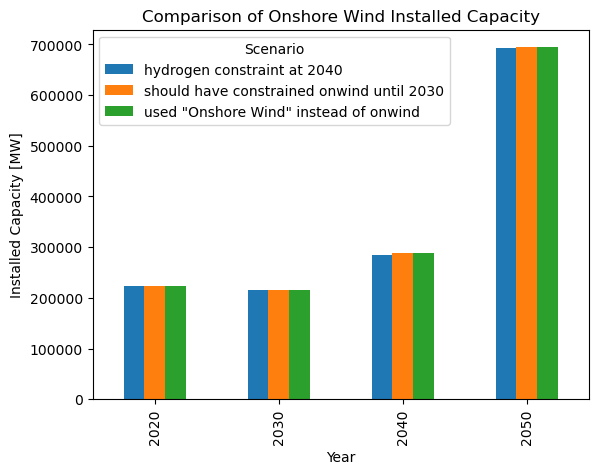

In [58]:
#One with no onshore wind until 2030
filepath_delay30_wind = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc'
delayed_wind_test_network = pypsa.Network(filepath_delay30_wind)
#capacities(delayed_wind_test_network)
delayed_wind_test_network.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']

#is this the same that was installed before 2020? (i.e, what what already made?)
filepath_delay20_wind = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc'
delayed_wind_test_network20 = pypsa.Network(filepath_delay20_wind)
#capacities(delayed_wind_test_network20)
delayed_wind_test_network20.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']

filepath_delay40_wind = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc'
delayed_wind_test_network40 = pypsa.Network(filepath_delay40_wind)
filepath_delay50_wind = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc'
delayed_wind_test_network50 = pypsa.Network(filepath_delay50_wind)

delayed_wind_different_word20 = pypsa.Network(filepath_delay20_wind)
delayed_wind_different_word30 = pypsa.Network(filepath_delay30_wind)
delayed_wind_different_word40 = pypsa.Network(filepath_delay40_wind)
delayed_wind_different_word50 = pypsa.Network(filepath_delay50_wind)


plot_installed_capacity_comparison(
    [delayed_wind_test_network20, delayed_wind_test_network, delayed_wind_test_network40, delayed_wind_test_network50], 'should have constrained onwind until 2030',
    [delayed_wind_different_word20, delayed_wind_different_word30, delayed_wind_different_word40, delayed_wind_different_word50], 'used "Onshore Wind" instead of onwind',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'hydrogen constraint at 2040',    
    'Generator', 'Onshore Wind'
)


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


<Figure size 800x500 with 0 Axes>

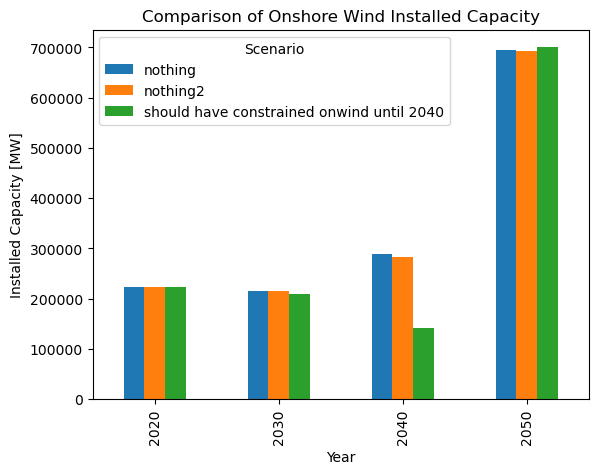

In [62]:

delayed_wind_different_word20 = pypsa.Network(filepath_delay20_wind)
delayed_wind_different_word30 = pypsa.Network(filepath_delay30_wind)
delayed_wind_different_word40 = pypsa.Network(filepath_delay40_wind)
delayed_wind_different_word50 = pypsa.Network(filepath_delay50_wind)

plot_installed_capacity_comparison(
    [delayed_wind_test_network20, delayed_wind_test_network, delayed_wind_test_network40, delayed_wind_test_network50], 'nothing',
    [delayed_wind_different_word20, delayed_wind_different_word30, delayed_wind_different_word40, delayed_wind_different_word50], 'should have constrained onwind until 2040',
    [myopic_constrained2040_20, myopic_constrained2040_30, myopic_constrained2040_40, myopic_constrained2040_50], 'nothing2',    
    'Generator', 'Onshore Wind'
)

In [ ]:
delayed_wind_different_growth30 = pypsa.Network(filepath_delay30_wind)
delayed_wind_different_growth40 = pypsa.Network(filepath_delay40_wind)


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [76]:
delayed_wind_different_growth20 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
delayed_wind_different_growth20.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


223007.931

In [77]:
delayed_wind_different_growth30 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
delayed_wind_different_growth30.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']

INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


216333.91098

In [79]:
delayed_wind_different_growth40 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
delayed_wind_different_growth40.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']

INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


288138.10941

In [80]:
delayed_wind_different_growth50 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')
delayed_wind_different_growth50.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']


INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


194085.09465

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:1264: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:1277: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:1278: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Deskto

(<matplotlib.collections.PatchCollection at 0x33a7ecef0>,
 <matplotlib.collections.LineCollection at 0x349f7a030>)

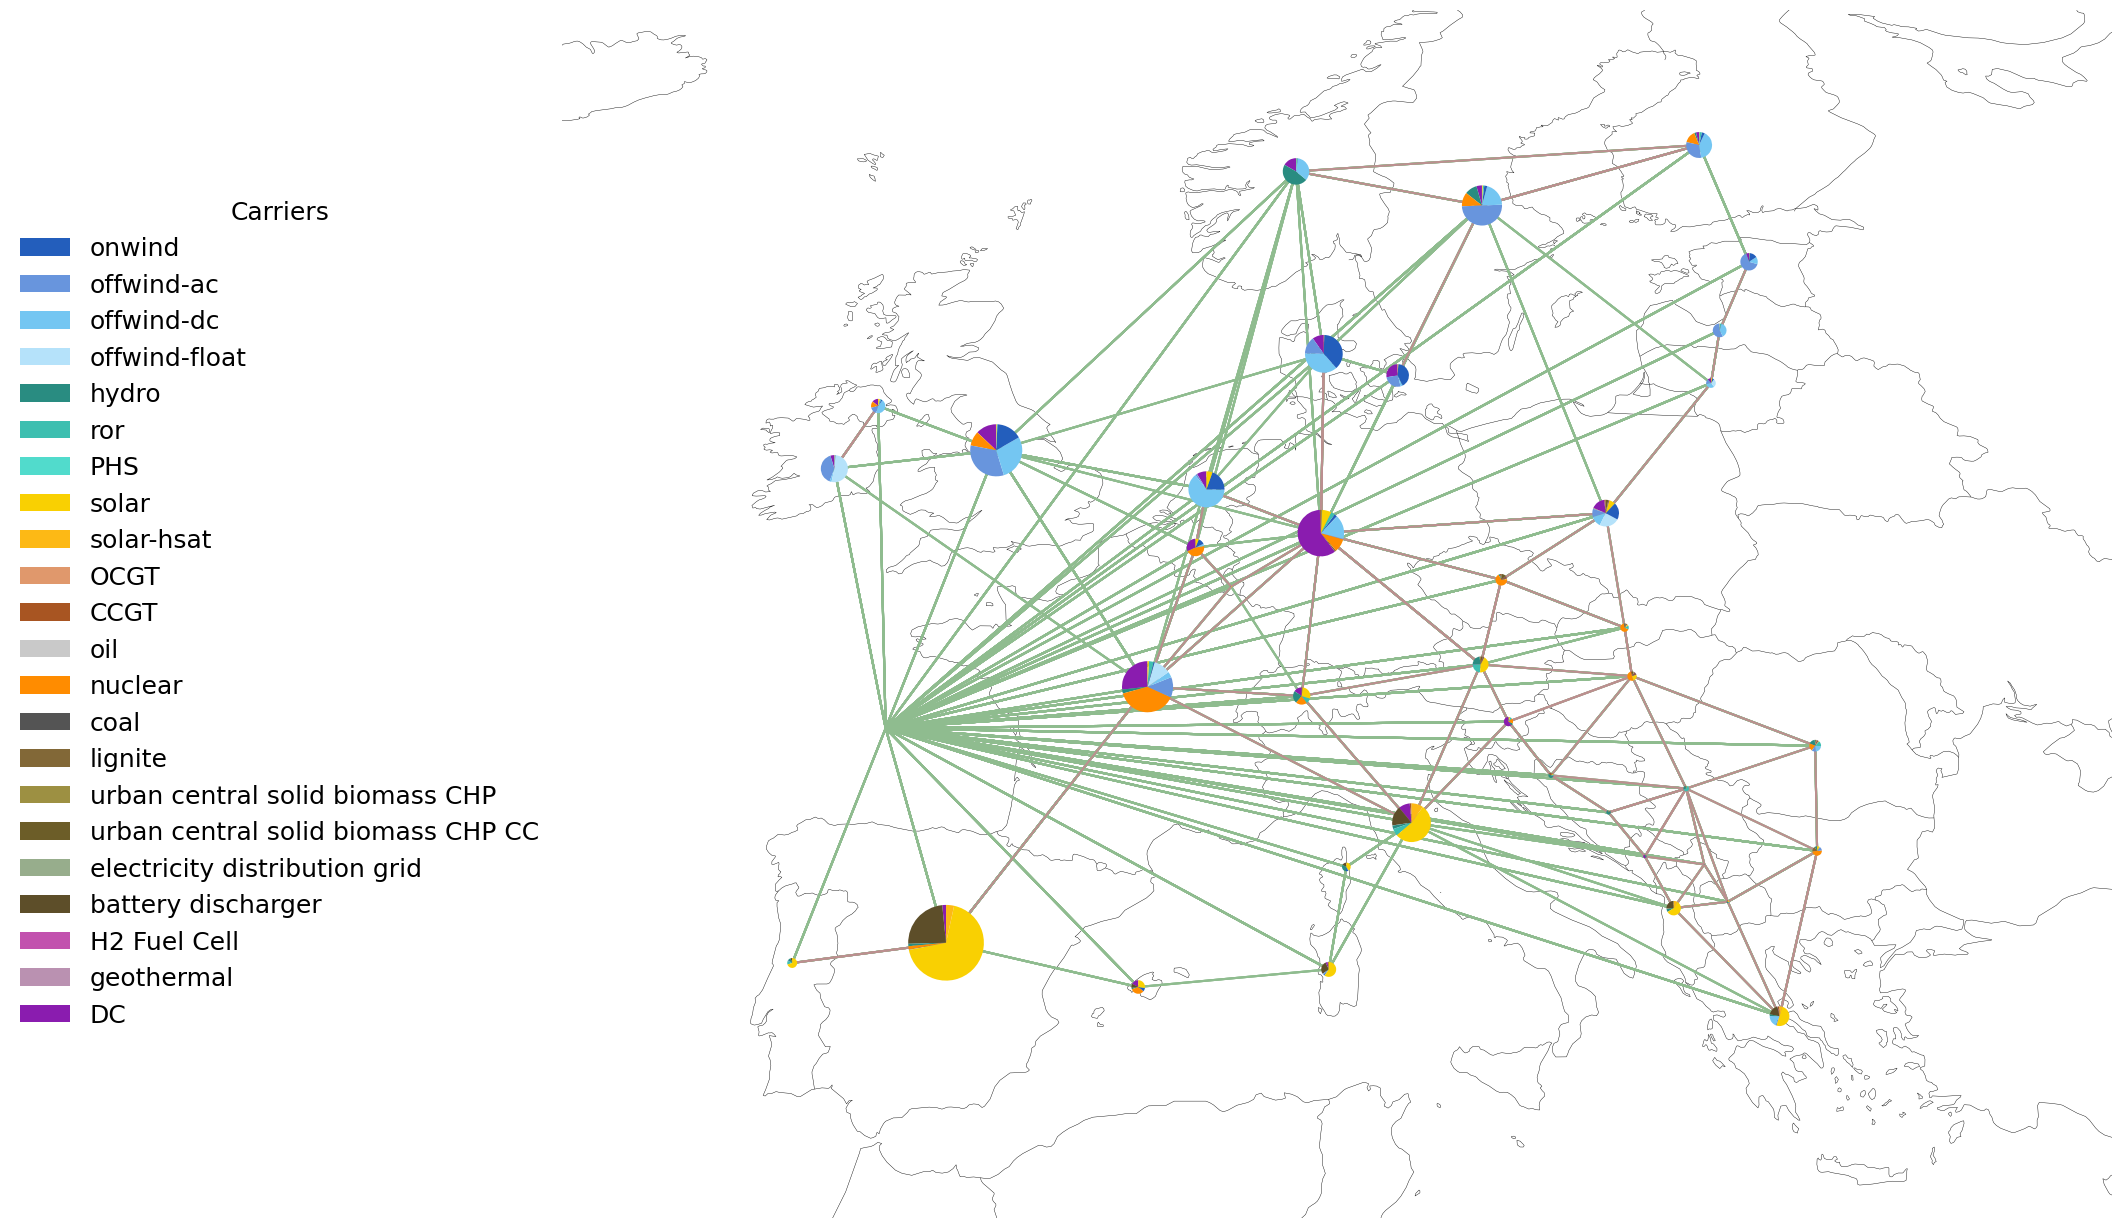

In [81]:
af.plot_network_test(delayed_wind_different_growth50, 'electric')

In [84]:
#Myopic tests with minimum as well for onshore wind 
wind_limits_tests20 = pypsa.Network(filepath_delay20_wind)
wind_limits_tests30 = pypsa.Network(filepath_delay30_wind)
wind_limits_tests40 = pypsa.Network(filepath_delay40_wind)
wind_limits_tests50 = pypsa.Network(filepath_delay50_wind)


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Text(0.5, 1.0, 'Installed Capacity of Onshore Wind with Minimum Growth Constraints')

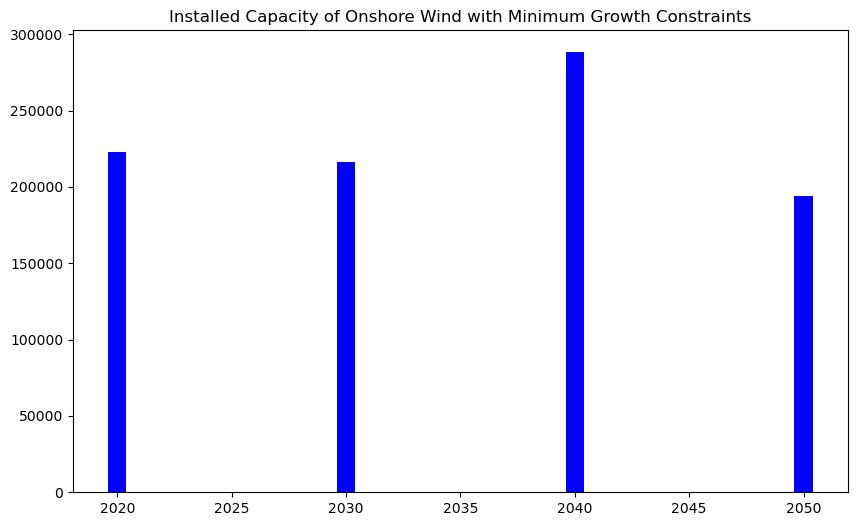

In [88]:
wind_installed_20 = wind_limits_tests20.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
wind_installed_30 = wind_limits_tests30.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
wind_installed_40 = wind_limits_tests40.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
wind_installed_50 = wind_limits_tests50.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
year = [2020, 2030, 2040, 2050]
wind_installed = [wind_installed_20, wind_installed_30, wind_installed_40, wind_installed_50]
plt.figure(figsize=(10, 6))
plt.bar(year, wind_installed,color='b')
plt.title('Installed Capacity of Onshore Wind with Minimum Growth Constraints')

In [89]:
wind_installed_50

194078.61542

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Text(0.5, 1.0, 'Installed Capacity of Onshore Wind with Minimum Growth Constraints')

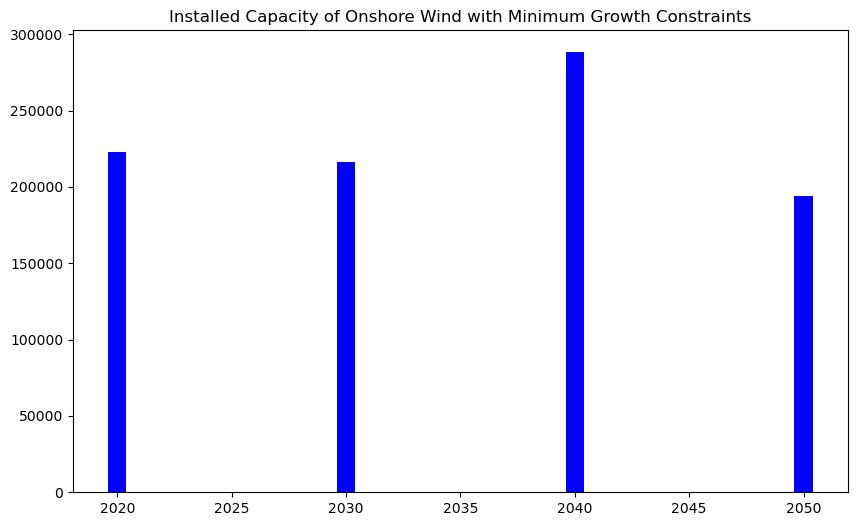

In [91]:
#Myopic tests with minimum as well for onshore wind -- minimum capacity instituted as 200 GW for every time period
wind_limits_tests20 = pypsa.Network(filepath_delay20_wind)
wind_limits_tests30 = pypsa.Network(filepath_delay30_wind)
wind_limits_tests40 = pypsa.Network(filepath_delay40_wind)
wind_limits_tests50 = pypsa.Network(filepath_delay50_wind)


wind_installed_20 = wind_limits_tests20.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
wind_installed_30 = wind_limits_tests30.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
wind_installed_40 = wind_limits_tests40.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
wind_installed_50 = wind_limits_tests50.statistics().loc[('Generator','Onshore Wind')]['Installed Capacity']
year = [2020, 2030, 2040, 2050]
wind_installed = [wind_installed_20, wind_installed_30, wind_installed_40, wind_installed_50]
plt.figure(figsize=(10, 6))
plt.bar(year, wind_installed,color='b')
plt.title('Installed Capacity of Onshore Wind with Minimum Growth Constraints')

In [95]:
print(wind_installed_20)
print(wind_installed_30)
print(wind_installed_40)
print(wind_installed_50)

223007.931
216337.99254
288156.48278
194081.03171


In [96]:
wind_limits_tests50.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
CO2Limit,co2_atmosphere,NaN,co2_emissions,<=,2.301959e+08,-33.913295
co2_sequestration_limit,operational_limit,NaN,co2 sequestered,>=,-2.000000e+08,3.365196
capacity_minimum-Europe-Generator-onwind,,NaN,,>=,5.918968e+03,3096.790872
capacity_maximum-Europe-Generator-onwind,,NaN,,<=,1.059190e+05,-0.000000


In [97]:
wind_limits_tests20 = pypsa.Network(filepath_delay20_wind)
wind_limits_tests20.global_constraints

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
CO2Limit,co2_atmosphere,NaN,co2_emissions,<=,3.314820e+09,-6.712942
co2_sequestration_limit,operational_limit,NaN,co2 sequestered,>=,0.000000e+00,0.000000
capacity_minimum-Europe-Generator-onwind,capacity_limit,NaN,,>=,7.712813e+04,31443.864039


In [ ]:
wind_limits_tests20 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [13]:
wind_limits_tests20.generators.columns

Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'e_sum_min',
       'e_sum_max', 'q_set', 'sign', 'carrier', 'marginal_cost',
       'marginal_cost_quadratic', 'active', 'build_year', 'lifetime',
       'capital_cost', 'efficiency', 'committable', 'start_up_cost',
       'shut_down_cost', 'stand_by_cost', 'min_up_time', 'min_down_time',
       'up_time_before', 'down_time_before', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down',
       'weight', 'p_nom_opt', 'location', 'unit'],
      dtype='object')

## Comparing the Constraints to No Constraints side by side

In [15]:
no_constraints20 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
no_constraints30 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
no_constraints40 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
no_constraints50 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [16]:
no_constraints20.statistics() 

Optimal Capacity  \
Generator Offshore Wind (AC)                            21956.18025   
          Offshore Wind (DC)                                0.02783   
          Offshore Wind (Floating)                          0.02503   
          Onshore Wind                                 210880.58513   
          Run of River                                  48341.66702   
...                                                             ...   
Store     oil                                              62.77993   
          residential rural water tanks                     0.27216   
          residential urban decentral water tanks           0.26717   
          uranium                                           1.17020   
          urban central water tanks                    235739.66368   

                                                   Installed Capacity  \
Generator Offshore Wind (AC)                              21956.15000   
          Offshore Wind (DC)                                  0.00000   
          Offshore Wind (Floating)                            0.00000   
          Onshore Wind                                   172871.86800   
          Run of River                                    48341.66702   
...                                                               ...   
Store     oil                                                 0.00000   
          residential rural water tanks                       0.00000   
          residential urban decentral water tanks             0.00000   
          uranium                                             0.00000   
          urban central water tanks                           0.00000   

                                                         Supply    Withdrawal  \
Generator Offshore Wind (AC)                       1.026511e+08  0.000000e+00   
          Offshore Wind (DC)                       1.065186e+02  0.000000e+00   
          Offshore Wind (Floating)                 6.120872e+01  0.000000e+00   
          Onshore Wind                             4.983462e+08  0.000000e+00   
          Run of River                             1.543796e+08  0.000000e+00   
...                                                         ...           ...   
Store     oil                                      2.765476e+01  2.765476e+01   
          residential rural water tanks            7.724600e+00  2.271809e+01   
          residential urban decentral water tanks  8.198180e+00  2.282508e+01   
          uranium                                  1.121200e-01  1.121200e-01   
          urban central water tanks                1.478896e+07  1.488415e+07   

                                                   Energy Balance  \
Generator Offshore Wind (AC)                         1.026511e+08   
          Offshore Wind (DC)                         1.065186e+02   
          Offshore Wind (Floating)                   6.120872e+01   
          Onshore Wind                               4.983462e+08   
          Run of River                               1.543796e+08   
...                                                           ...   
Store     oil                                        0.000000e+00   
          residential rural water tanks             -1.499349e+01   
          residential urban decentral water tanks   -1.462689e+01   
          uranium                                    0.000000e+00   
          urban central water tanks                 -9.518589e+04   

                                                   Transmission  \
Generator Offshore Wind (AC)                                0.0   
          Offshore Wind (DC)                                0.0   
          Offshore Wind (Floating)                          0.0   
          Onshore Wind                                      0.0   
          Run of River                                      0.0   
...                                                         ...   
Store     oil                                     

In [17]:
no_constraints30.statistics() 

Optimal Capacity  Installed Capacity  \
Generator Offshore Wind (AC)                28167.99212         21893.20000   
          Offshore Wind (DC)                32520.93461             0.00000   
          Offshore Wind (Floating)              0.03030             0.00000   
          Onshore Wind                     343164.44223        198209.93124   
          Run of River                      48341.66702         48341.66702   
...                                                 ...                 ...   
Store     oil                                  30.10037             0.00000   
          rural water tanks                     0.13496             0.00000   
          uranium                               0.53927             0.00000   
          urban central water tanks        540212.24943        235739.66368   
          urban decentral water tanks           0.13590             0.00000   

                                             Supply    Withdrawal  \
Generator Offshore Wind (AC)           1.296351e+08  0.000000e+00   
          Offshore Wind (DC)           1.724434e+08  0.000000e+00   
          Offshore Wind (Floating)     8.125910e+01  0.000000e+00   
          Onshore Wind                 9.181156e+08  0.000000e+00   
          Run of River                 1.543459e+08  0.000000e+00   
...                                             ...           ...   
Store     oil                          1.965735e+02  1.965735e+02   
          rural water tanks            6.615740e+00  1.425716e+01   
          uranium                      4.814000e-02  4.814000e-02   
          urban central water tanks    2.536431e+07  2.560699e+07   
          urban decentral water tanks  7.989820e+00  1.559065e+01   

                                       Energy Balance  Transmission  \
Generator Offshore Wind (AC)             1.296351e+08           0.0   
          Offshore Wind (DC)             1.724434e+08           0.0   
          Offshore Wind (Floating)       8.125910e+01           0.0   
          Onshore Wind                   9.181156e+08           0.0   
          Run of River                   1.543459e+08           0.0   
...                                               ...           ...   
Store     oil                            0.000000e+00           0.0   
          rural water tanks             -7.641420e+00           0.0   
          uranium                        0.000000e+00           0.0   
          urban central water tanks     -2.426806e+05           0.0   
          urban decentral water tanks   -7.600830e+00           0.0   

                                       Capacity Factor   Curtailment  \
Generator Offshore Wind (AC)                  0.525367  1.467095e+06   
          Offshore Wind (DC)                  0.605312  3.246429e+04   
          Offshore Wind (Floating)            0.306271  2.738089e+01   
          Onshore Wind                        0.305415  1.396028e+07   
          Run of River                        0.364476  3.446997e+04   
...                                                ...           ...   
Store     oil                                 0.510206  0.000000e+00   
          rural water tanks                   0.483625  0.000000e+00   
          uranium                             0.044505  0.000000e+00   
          urban central water tanks           0.221693  0.000000e+00   
          urban decentral water tanks         0.479102  0.000000e+00   

                                       Capital Expenditure  \
Generator Offshore Wind (AC)                  6.630089e+09   
          Offshore Wind (DC)                  7.529625e+09   
          Offshore Wind (Floating)            6.947969e+03   
          Onshore Wind                        4.207757e+10   
          Run of River                        1.489747e+10   
...                                                    ...   
Store     oil                                 8.215126e+01   
          rural water tanks                   3

In [18]:
no_constraints40.statistics() 

Optimal Capacity  Installed Capacity  \
Generator Offshore Wind (AC)               2.054302e+05         25316.03785   
          Offshore Wind (DC)               2.464756e+05         32520.82184   
          Offshore Wind (Floating)         1.190800e-01             0.00000   
          Onshore Wind                     7.932326e+05        274060.53501   
          Run of River                     4.834167e+04         48341.66702   
...                                                 ...                 ...   
Store     oil                              3.149236e+01             0.00000   
          rural water tanks                1.420800e-01             0.00000   
          uranium                          5.192100e-01             0.00000   
          urban central water tanks        6.787460e+06        540199.15124   
          urban decentral water tanks      1.374000e-01             0.00000   

                                             Supply    Withdrawal  \
Generator Offshore Wind (AC)           8.855037e+08  0.000000e+00   
          Offshore Wind (DC)           1.258118e+09  0.000000e+00   
          Offshore Wind (Floating)     3.666153e+02  0.000000e+00   
          Onshore Wind                 2.225106e+09  0.000000e+00   
          Run of River                 1.543297e+08  0.000000e+00   
...                                             ...           ...   
Store     oil                          1.230666e+03  1.230666e+03   
          rural water tanks            9.013700e+00  1.687535e+01   
          uranium                      2.859000e-02  2.859000e-02   
          urban central water tanks    1.577987e+08  1.637867e+08   
          urban decentral water tanks  9.292210e+00  1.686614e+01   

                                       Energy Balance  Transmission  \
Generator Offshore Wind (AC)             8.855037e+08           0.0   
          Offshore Wind (DC)             1.258118e+09           0.0   
          Offshore Wind (Floating)       3.666153e+02           0.0   
          Onshore Wind                   2.225106e+09           0.0   
          Run of River                   1.543297e+08           0.0   
...                                               ...           ...   
Store     oil                            0.000000e+00           0.0   
          rural water tanks             -7.861660e+00           0.0   
          uranium                        0.000000e+00           0.0   
          urban central water tanks     -5.987988e+06           0.0   
          urban decentral water tanks   -7.573940e+00           0.0   

                                       Capacity Factor   Curtailment  \
Generator Offshore Wind (AC)                  0.492064  3.103626e+07   
          Offshore Wind (DC)                  0.582698  4.871134e+06   
          Offshore Wind (Floating)            0.351444  8.372273e+01   
          Onshore Wind                        0.320218  9.256065e+07   
          Run of River                        0.364438  5.070514e+04   
...                                                ...           ...   
Store     oil                                 0.513247  0.000000e+00   
          rural water tanks                   0.474873  0.000000e+00   
          uranium                             0.027465  0.000000e+00   
          urban central water tanks           0.435366  0.000000e+00   
          urban decentral water tanks         0.470378  0.000000e+00   

                                       Capital Expenditure  \
Generator Offshore Wind (AC)                  3.995792e+10   
          Offshore Wind (DC)                  5.388600e+10   
          Offshore Wind (Floating)            2.535446e+04   
          Onshore Wind                        9.021292e+10   
          Run of River                        1.489747e+10   
...                                                    ...   
Store     oil                                 8.595036e+01   
          rural water tanks                   4

In [19]:
no_constraints50.statistics() 

Optimal Capacity  Installed Capacity  \
Generator Offshore Wind (AC)               1.863889e+05        1.863889e+05   
          Offshore Wind (DC)               2.464756e+05        2.464756e+05   
          Offshore Wind (Floating)         5.550000e-03        0.000000e+00   
          Onshore Wind                     6.754287e+05        6.641263e+05   
          Run of River                     4.834167e+04        4.834167e+04   
...                                                 ...                 ...   
Store     oil                              7.063110e+00        0.000000e+00   
          rural water tanks                3.038000e-02        0.000000e+00   
          uranium                          1.302700e-01        0.000000e+00   
          urban central water tanks        6.787466e+06        6.787460e+06   
          urban decentral water tanks      2.883000e-02        0.000000e+00   

                                             Supply    Withdrawal  \
Generator Offshore Wind (AC)           8.144566e+08  0.000000e+00   
          Offshore Wind (DC)           1.261741e+09  0.000000e+00   
          Offshore Wind (Floating)     1.209011e+01  0.000000e+00   
          Onshore Wind                 2.001839e+09  0.000000e+00   
          Run of River                 1.543726e+08  0.000000e+00   
...                                             ...           ...   
Store     oil                          3.004844e+01  3.004844e+01   
          rural water tanks            1.063340e+00  2.773920e+00   
          uranium                      8.510000e-03  8.510000e-03   
          urban central water tanks    1.342972e+08  1.396907e+08   
          urban decentral water tanks  6.044200e-01  2.241200e+00   

                                       Energy Balance  Transmission  \
Generator Offshore Wind (AC)             8.144566e+08           0.0   
          Offshore Wind (DC)             1.261741e+09           0.0   
          Offshore Wind (Floating)       1.209011e+01           0.0   
          Onshore Wind                   2.001839e+09           0.0   
          Run of River                   1.543726e+08           0.0   
...                                               ...           ...   
Store     oil                            0.000000e+00           0.0   
          rural water tanks             -1.710580e+00           0.0   
          uranium                        0.000000e+00           0.0   
          urban central water tanks     -5.393449e+06           0.0   
          urban decentral water tanks   -1.636770e+00           0.0   

                                       Capacity Factor   Curtailment  \
Generator Offshore Wind (AC)                  0.498820  1.317137e+07   
          Offshore Wind (DC)                  0.584376  1.247376e+06   
          Offshore Wind (Floating)            0.248649  6.293360e+00   
          Onshore Wind                        0.338334  3.112136e+07   
          Run of River                        0.364539  7.776674e+03   
...                                                ...           ...   
Store     oil                                 0.515631  0.000000e+00   
          rural water tanks                   0.483871  0.000000e+00   
          uranium                             0.032625  0.000000e+00   
          urban central water tanks           0.392139  0.000000e+00   
          urban decentral water tanks         0.485952  0.000000e+00   

                                       Capital Expenditure  \
Generator Offshore Wind (AC)                  3.529445e+10   
          Offshore Wind (DC)                  5.388599e+10   
          Offshore Wind (Floating)            1.162477e+03   
          Onshore Wind                        7.495420e+10   
          Run of River                        1.489747e+10   
...                                                    ...   
Store     oil                                 1.927694e+01   
          rural water tanks                   8

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:1264: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:1277: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:1278: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Deskto

(<matplotlib.collections.PatchCollection at 0x108243da0>,
 <matplotlib.collections.LineCollection at 0x10c8f11f0>)

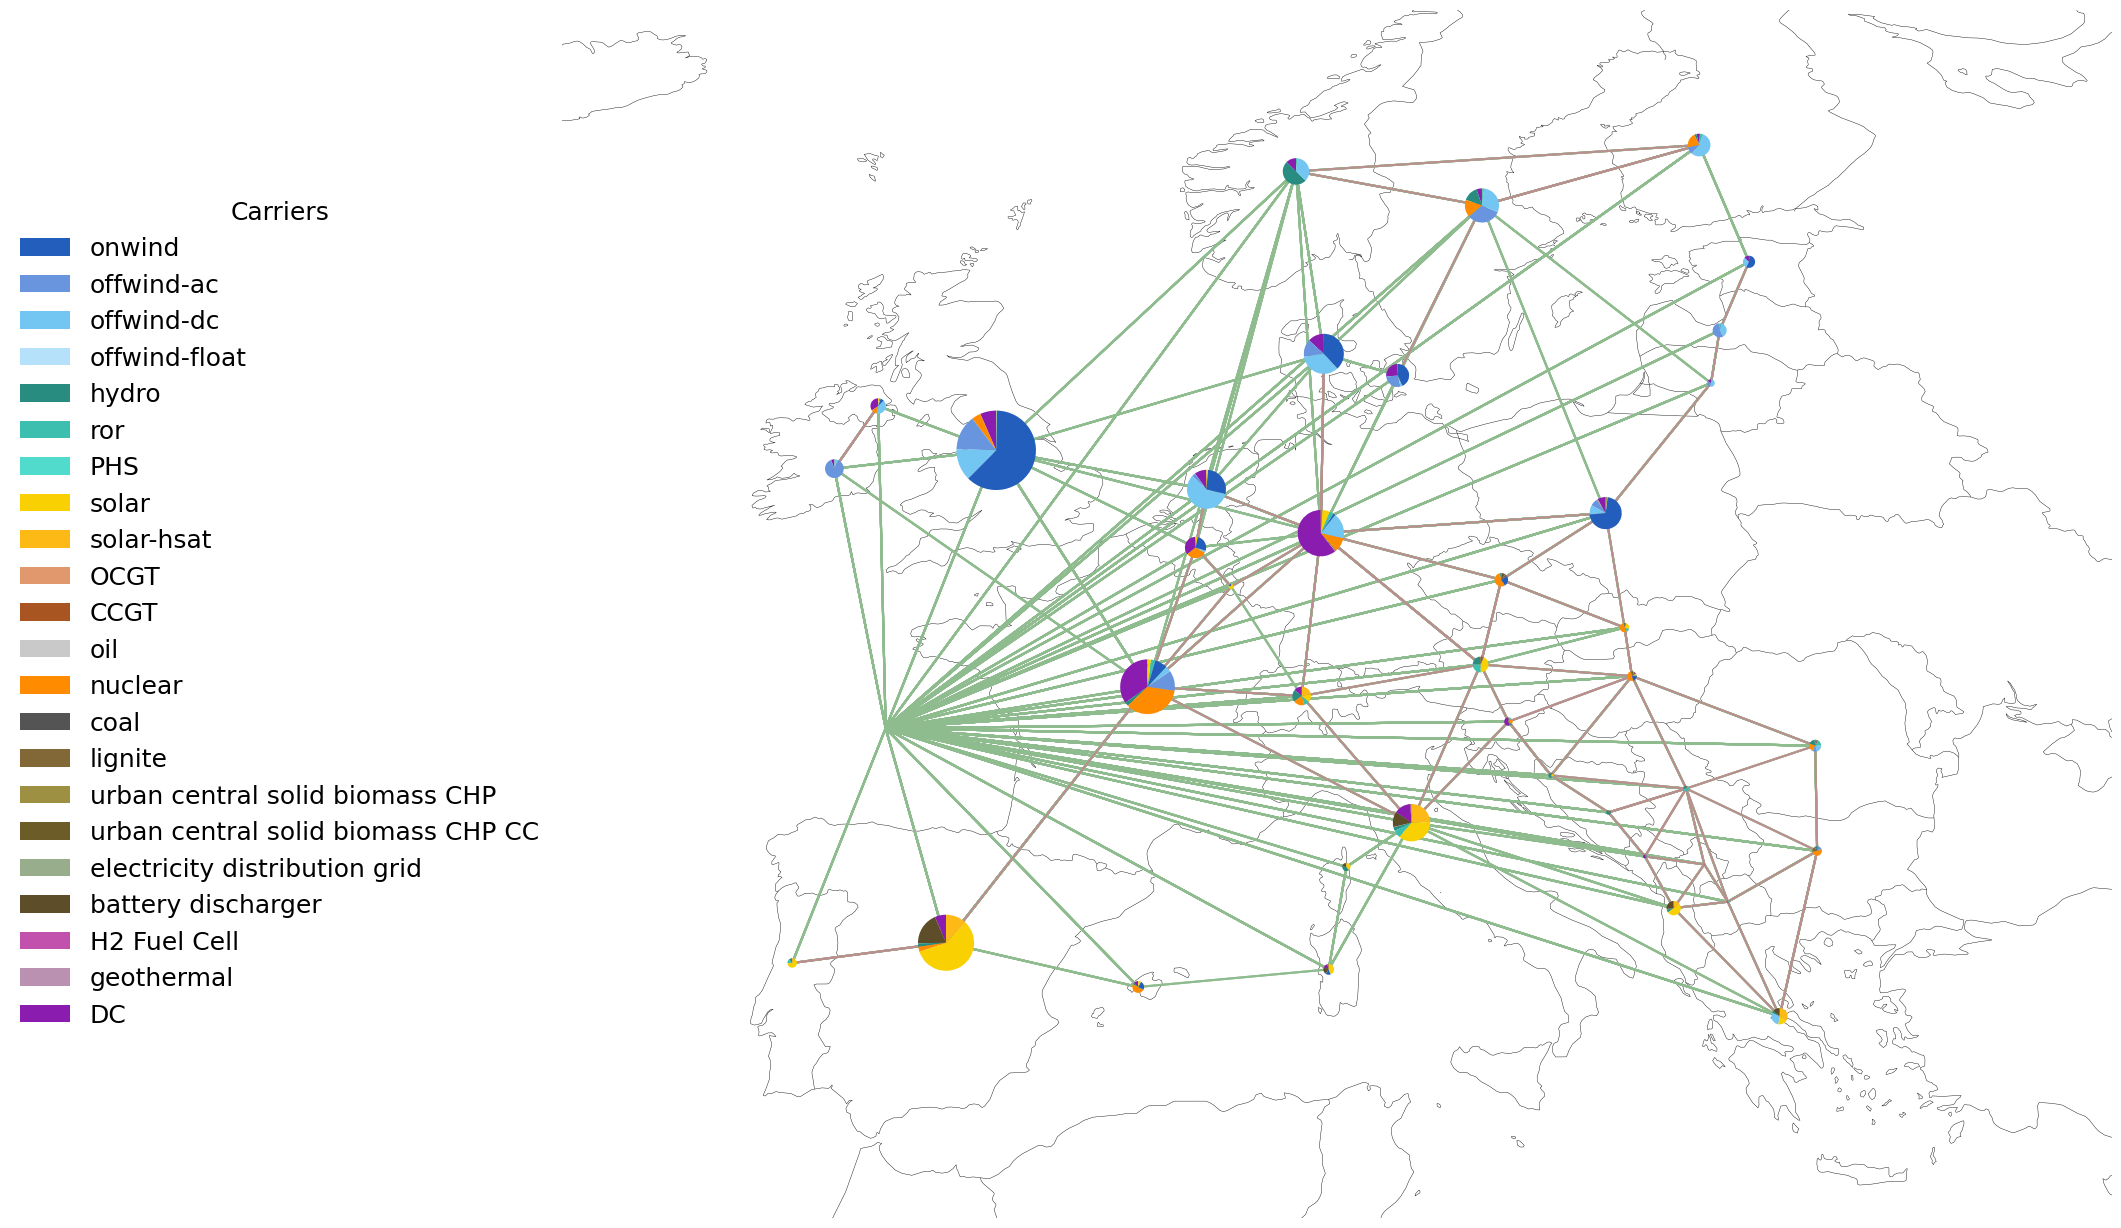

In [24]:
af.plot_network_test(no_constraints50, 'electric')

In [34]:
# Get data for both scenarios
def compare_networks(networks, component, technology):
    """
    Compare a specific component and technology across multiple networks.

    Parameters:
    networks (list): List of pypsa.Network objects.
    component (str): The component type, e.g., 'Generator', 'Link', 'Store'.
    technology (str): The technology/carrier name, e.g., 'Solar', 'H2 Store'.

    Returns:
    pd.DataFrame: DataFrame containing the comparison results.
    """
    years = [2020, 2030, 2040, 2050]
    comparison_dataframe = pd.DataFrame(columns=['Year', 'Item', 'Value', 'Unit'])
    for idx, net in enumerate(networks):
        item = (component, technology)
        if item in net.statistics().index:
            value = net.statistics().loc[item, 'Installed Capacity'] #difference between Installed Capacity and Optimal Capacity
            comparison_dataframe.loc[len(comparison_dataframe)] = {
                'Year': years[idx], 'Item': item, 'Value': value, 'Unit': 'MW'
            }
        else:
            print(f"Item {item} not found in network {getattr(net, 'name', idx)}.")
    return comparison_dataframe



In [27]:
compare_networks([no_constraints20, no_constraints30, no_constraints40, no_constraints50], 'Generator', 'Onshore Wind')

,Year,Item,Value,Unit
0,2020,"(Generator, Onshore Wind)",172871.86800,MW
1,2030,"(Generator, Onshore Wind)",198209.93124,MW
2,2040,"(Generator, Onshore Wind)",274060.53501,MW
3,2050,"(Generator, Onshore Wind)",664126.31153,MW


In [28]:
restricted_onshore_wind_200_20 = pypsa.Network('/Users/katherine.shaw/Desktop/networks_copy_200_constraints/base_s_39___2020.nc')
restricted_onshore_wind_200_30 = pypsa.Network('/Users/katherine.shaw/Desktop/networks_copy_200_constraints/base_s_39___2030.nc')
restricted_onshore_wind_200_40 = pypsa.Network('/Users/katherine.shaw/Desktop/networks_copy_200_constraints/base_s_39___2040.nc')
restricted_onshore_wind_200_50 = pypsa.Network('/Users/katherine.shaw/Desktop/networks_copy_200_constraints/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [29]:
compare_networks([restricted_onshore_wind_200_20, restricted_onshore_wind_200_30, restricted_onshore_wind_200_40, restricted_onshore_wind_200_50], 'Generator', 'Onshore Wind')

,Year,Item,Value,Unit
0,2020,"(Generator, Onshore Wind)",172871.86800,MW
1,2030,"(Generator, Onshore Wind)",160201.30300,MW
2,2040,"(Generator, Onshore Wind)",130896.10805,MW
3,2050,"(Generator, Onshore Wind)",108902.39563,MW


In [30]:
def plot_installed_capacity_comparison(network_set1, networks_label1, network_set2, networks_label2, component, technology):
    """
    Plots a grouped bar chart comparing installed capacity of a given component and technology
    across two sets of networks (e.g., unconstrained vs constrained scenarios).

    Parameters:
    network_set1 (list): List of pypsa.Network objects for scenario 1.
    network_set2 (list): List of pypsa.Network objects for scenario 2.
    component (str): The component type, e.g., 'Generator', 'Link', 'Store'.
    technology (str): The technology/carrier name, e.g., 'Solar', 'H2 Store'.
    """
    years = [2020, 2030, 2040, 2050]
    '''
    def compare_networks(networks, component, technology):
        comparison_dataframe = pd.DataFrame(columns=['Year', 'Item', 'Value', 'Unit'])
        for idx, net in enumerate(networks):
            item = (component, technology)
            if item in net.statistics().index:
                value = net.statistics().loc[item, 'Installed Capacity']
                comparison_dataframe.loc[len(comparison_dataframe)] = {
                    'Year': years[idx], 'Item': item, 'Value': value, 'Unit': 'MW'
                }
            else:
                print(f"Item {item} not found in network {getattr(net, 'name', idx)}.")
        return comparison_dataframe
    '''
    df1 = compare_networks(network_set1, component, technology)
    df1['Scenario'] = networks_label1
    df2 = compare_networks(network_set2, component, technology)
    df2['Scenario'] = networks_label2
    

    df_combined = pd.concat([df1, df2])
    df_pivot = df_combined.pivot(index='Year', columns='Scenario', values='Value')

    # Set unit
    unit = 'MWh' if component == 'Store' else 'MW'
    plt.figure(figsize=(8, 5))
    df_pivot.plot(kind='bar')
    plt.ylabel(f'Installed Capacity [{unit}]')
    plt.title(f'Comparison of {technology} Installed Capacity')
    plt.show()

    return None

<Figure size 800x500 with 0 Axes>

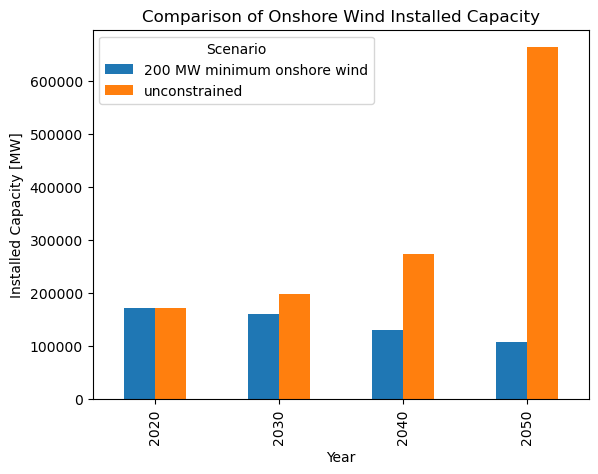

In [35]:
plot_installed_capacity_comparison(
    [no_constraints20, no_constraints30, no_constraints40, no_constraints50], 'unconstrained',
    [restricted_onshore_wind_200_20, restricted_onshore_wind_200_30, restricted_onshore_wind_200_40, restricted_onshore_wind_200_50], '200 MW minimum onshore wind',
    'Generator', 'Onshore Wind'
)

In [47]:
def plot_installed_capacity_comparison(network_set1, networks_label1, network_set2, networks_label2, network_set3, networks_label3, component, technology):
    """
    Plots a grouped bar chart comparing installed capacity of a given component and technology
    across two sets of networks (e.g., unconstrained vs constrained scenarios).

    Parameters:
    network_set1 (list): List of pypsa.Network objects for scenario 1.
    network_set2 (list): List of pypsa.Network objects for scenario 2.
    component (str): The component type, e.g., 'Generator', 'Link', 'Store'.
    technology (str): The technology/carrier name, e.g., 'Solar', 'H2 Store'.
    """
    years = [2020, 2030, 2040, 2050]
    '''
    def compare_networks(networks, component, technology):
        comparison_dataframe = pd.DataFrame(columns=['Year', 'Item', 'Value', 'Unit'])
        for idx, net in enumerate(networks):
            item = (component, technology)
            if item in net.statistics().index:
                value = net.statistics().loc[item, 'Installed Capacity']
                comparison_dataframe.loc[len(comparison_dataframe)] = {
                    'Year': years[idx], 'Item': item, 'Value': value, 'Unit': 'MW'
                }
            else:
                print(f"Item {item} not found in network {getattr(net, 'name', idx)}.")
        return comparison_dataframe
    '''
    df1 = compare_networks(network_set1, component, technology)
    df1['Scenario'] = networks_label1
    df2 = compare_networks(network_set2, component, technology)
    df2['Scenario'] = networks_label2
    df3 = compare_networks(network_set3, component, technology)
    df3['Scenario'] = networks_label3

    df_combined = pd.concat([df1, df2])
    df_combined = pd.concat([df_combined, df3])
    df_pivot = df_combined.pivot(index='Year', columns='Scenario', values='Value')

    # Set unit
    unit = 'MWh' if component == 'Store' else 'MW'
    plt.figure(figsize=(8, 5))
    df_pivot.plot(kind='bar')
    plt.ylabel(f'Installed Capacity [{unit}]')
    plt.title(f'Comparison of {technology} Installed Capacity')
    plt.show()

    return None

In [36]:
wind_delay_2030_20 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
wind_delay_2030_30 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
wind_delay_2030_40 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
wind_delay_2030_50 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [40]:
wind_delay_2040_20 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
wind_delay_2040_30 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
wind_delay_2040_40 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
wind_delay_2040_50 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


<Figure size 800x500 with 0 Axes>

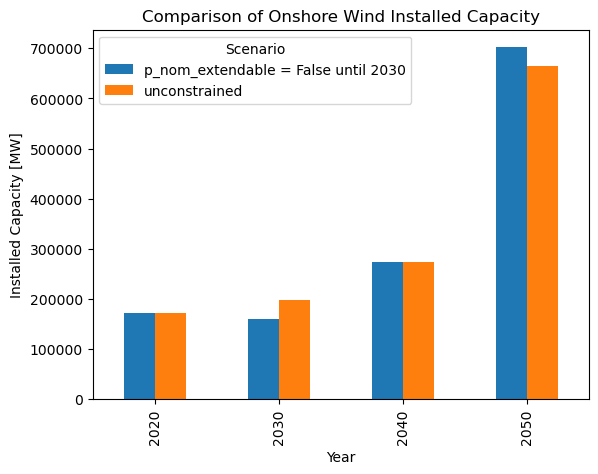

In [37]:
plot_installed_capacity_comparison(
    [no_constraints20, no_constraints30, no_constraints40, no_constraints50], 'unconstrained',
    [wind_delay_2030_20, wind_delay_2030_30, wind_delay_2030_40, wind_delay_2030_50], 'p_nom_extendable = False until 2030',
    'Generator', 'Onshore Wind'
)

In [43]:
plot_installed_capacity_comparison(
    [no_constraints20, no_constraints30, no_constraints40, no_constraints50], 'unconstrained',
    [wind_delay_2030_20, wind_delay_2030_30, wind_delay_2030_40, wind_delay_2030_50], 'p_nom_extendable = False until 2030',
    [wind_delay_2040_20, wind_delay_2040_30, wind_delay_2040_40, wind_delay_2040_50], 'p_nom_extendable = False until 2030',
    'Generator', 'Onshore Wind'
)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
no_constraints_df = compare_networks([no_constraints20, no_constraints30, no_constraints40, no_constraints50], 'Generator', 'Onshore Wind')


,Year,Item,Value,Unit
0,2020,"(Generator, Onshore Wind)",172871.86800,MW
1,2030,"(Generator, Onshore Wind)",198209.93124,MW
2,2040,"(Generator, Onshore Wind)",274060.53501,MW
3,2050,"(Generator, Onshore Wind)",664126.31153,MW


In [ ]:
constraint_30_df = compare_networks([wind_delay_2030_20, wind_delay_2030_30, wind_delay_2030_40, wind_delay_2030_50], 'Generator', 'Onshore Wind')

,Year,Item,Value,Unit
0,2020,"(Generator, Onshore Wind)",172871.86800,MW
1,2030,"(Generator, Onshore Wind)",160201.30300,MW
2,2040,"(Generator, Onshore Wind)",274064.50478,MW
3,2050,"(Generator, Onshore Wind)",702102.68960,MW


In [ ]:
constraint_40_df = compare_networks([wind_delay_2040_20, wind_delay_2040_30, wind_delay_2040_40, wind_delay_2040_50], 'Generator', 'Onshore Wind')

,Year,Item,Value,Unit
0,2020,"(Generator, Onshore Wind)",172871.86800,MW
1,2030,"(Generator, Onshore Wind)",160201.30300,MW
2,2040,"(Generator, Onshore Wind)",91097.47900,MW
3,2050,"(Generator, Onshore Wind)",702082.12051,MW


<Figure size 800x500 with 0 Axes>

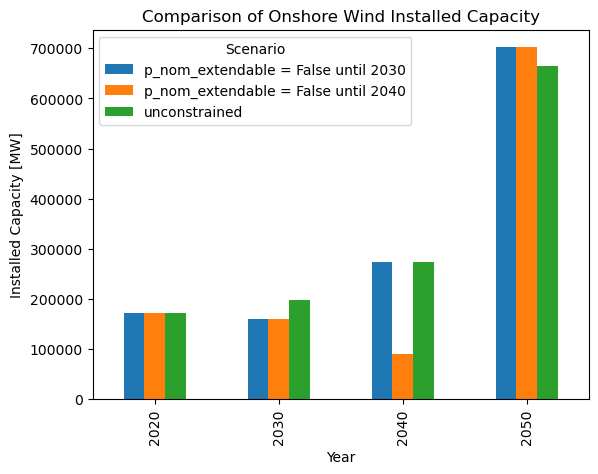

In [49]:
plot_installed_capacity_comparison(
    [no_constraints20, no_constraints30, no_constraints40, no_constraints50], 'unconstrained',
    [wind_delay_2030_20, wind_delay_2030_30, wind_delay_2030_40, wind_delay_2030_50], 'p_nom_extendable = False until 2030',
    [wind_delay_2040_20, wind_delay_2040_30, wind_delay_2040_40, wind_delay_2040_50], 'p_nom_extendable = False until 2040',
    'Generator', 'Onshore Wind'
)


## 

In [50]:
wind_minimum_250_20 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
wind_minimum_250_30 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
wind_minimum_250_40 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
wind_minimum_250_50 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [51]:
compare_networks([wind_minimum_250_20, wind_minimum_250_30, wind_minimum_250_40, wind_minimum_250_50], 'Generator', 'Onshore Wind')

,Year,Item,Value,Unit
0,2020,"(Generator, Onshore Wind)",172871.86800,MW
1,2030,"(Generator, Onshore Wind)",237329.31305,MW
2,2040,"(Generator, Onshore Wind)",276526.12328,MW
3,2050,"(Generator, Onshore Wind)",623731.90762,MW


In [52]:
compare_networks([no_constraints20, no_constraints30, no_constraints40, no_constraints50], 'Generator', 'Onshore Wind')

,Year,Item,Value,Unit
0,2020,"(Generator, Onshore Wind)",172871.86800,MW
1,2030,"(Generator, Onshore Wind)",198209.93124,MW
2,2040,"(Generator, Onshore Wind)",274060.53501,MW
3,2050,"(Generator, Onshore Wind)",664126.31153,MW
